In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from scipy import constants

from pyrfu import pyrf, mms
from pyrfu.plot import make_labels, plot_spectr, plot_line

from ionaniso.utils import average_mom, average_vdf, conditional_avg
from ionaniso.load import load_fpi_dis_mmsx, load_rsc_bfield_mmsx, load_efield_mmsx
from ionaniso.plot import add_threshold
plt.style.use("./aps.mplstyle")

Load IGRF coefficients ...


## Figure 1: Slices of Brazil plot

In [2]:
n_avg = 3
brazil = xr.load_dataset(
    os.path.join(
        os.getcwd(), "data", f"mms_bbfsdb_brst_2017-2021_t-anisotropy_avg_{int(n_avg * 150):04}.nc"
    )
)

braqps = xr.load_dataset(
    os.path.join(
        os.pardir, "data", "mms_quietpsheet_2017-2021_t-anisotropy.nc"
    )
)

In [3]:
# BBFS
# Compute ion plasma beta (parallel, perpendicular and total)
b_mag = pyrf.norm(brazil.b_gsm)
p_mag = 1e-18 * b_mag ** 2 / (2 * constants.mu_0)  # old
p_i_para = 1e6 * brazil.n_i.data * constants.electron_volt * brazil.t_para_i
p_i_perp = 1e6 * brazil.n_i.data * constants.electron_volt * brazil.t_perp_i
beta_para = p_i_para / p_mag
beta_perp = p_i_perp / p_mag
beta_tota = (beta_para + 2 * beta_perp) / 3

# Compute temperature anisotropy
t_aniso = brazil.t_perp_i / brazil.t_para_i.data
t_agyro = brazil.lambda_t[:, 1] / brazil.lambda_t[:, 2]

In [4]:
t_aniso_qps = braqps.t_perp / braqps.t_para
beta_tota_qps = (braqps.beta_para + 2 * braqps.beta_perp) / 3

idx = np.logical_and(t_aniso_qps < 100, t_aniso_qps > .1)
t_aniso_qps = t_aniso_qps[idx]
beta_tota_qps = beta_tota_qps[idx]

In [5]:
beta_edges = np.logspace(np.log10(0.5), 1, 5)

array([<Axes: xlabel='$T_{i\\perp}/T_{i\\parallel}$', ylabel='counts (jets)'>,
       <Axes: xlabel='$T_{i\\perp}/T_{i\\parallel}$', ylabel='counts (jets)'>],
      dtype=object)

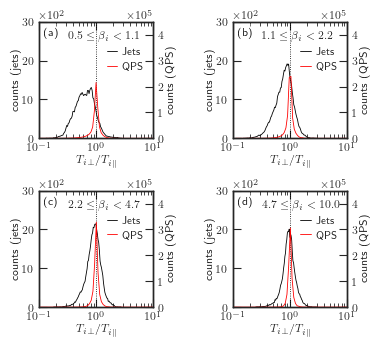

In [6]:
f, axs = plt.subplots(2, 2, figsize=(4, 3.5))
f.subplots_adjust(hspace=.45, wspace=.7, left=.115, right=.885, bottom=.105, top=.92)

axsb = [ax.twinx() for ax in axs.reshape(4)] 
for (i, ax), axb in zip(enumerate(axs.reshape(4)), axsb):
    idx_b = np.logical_and(beta_tota >= beta_edges[i], beta_tota < beta_edges[i+1])
    h = pyrf.histogram(np.log10(t_aniso[idx_b]), density=False)
    l0, = ax.plot(10 ** h.bins, h.data, color="k")
    ax.ticklabel_format(axis='y', style='sci', scilimits=(2, 2))
    
    idx_b = np.logical_and(beta_tota_qps > beta_edges[i], beta_tota_qps < beta_edges[i+1])
    h = pyrf.histogram(np.log10(t_aniso_qps[idx_b]), density=False)
    l1, = axb.plot(10 ** h.bins, h.data, color="r")
    axb.ticklabel_format(axis='y', style='sci', scilimits=(5, 5))
    ax.set_xscale("log")
    ax.set_xlim([.1, 10])
    ax.set_ylim([0, 30e2])
    axb.set_ylim([0, 4.5e5])
    ax.legend([l0, l1], ["Jets", "QPS"], loc="upper left", handlelength=1., bbox_to_anchor=(.5, .87))
    ax.text(0.25, .85, f"${beta_edges[i]:2.1f}\\leq \\beta_i < {beta_edges[i+1]:2.1f}$", horizontalalignment="left", transform=ax.transAxes)
    ax.set_xlabel("$T_{i\\perp}/T_{i\\parallel}$")
    ax.set_ylabel("counts (jets)")
    axb.set_ylabel("counts (QPS)")
    ax.axvline(1., color="k", linestyle=":")

bbox = dict(boxstyle="square", ec=(1.0, 1.0, 1.0), fc=(1.0, 1.0, 1.0), alpha=.2)
make_labels(axs[0, :], (0.035, 0.88), pad=0, zorder=2, bbox=bbox)
make_labels(axs[1, :], (0.035, 0.88), pad=2, zorder=2, bbox=bbox)
#f.savefig("../figures/draft/figure_si_1.pdf")

## Figure 2: convergence non-Maxwellianity

In [7]:
bbfs = pd.read_csv(
    os.path.join(os.pardir, "data", "mms_bbfsdb_brst_2017-2021.csv"), header=None)
data = xr.load_dataset(
    os.path.join(os.pardir, "data", "mms_bbfsdb_brst_2017-2021.nc"))
cond_cps = np.logical_and(np.abs(data.y.data / 6371) < 12, data.beta.data > 0.5)
tint = bbfs.values[cond_cps][172]
print(tint)

['2017-08-21T11:33:51.542371000' '2017-08-21T11:35:35.043129000']


In [8]:
# Load magnetic field averaged across the spacecraft
_, b_dmpa, b_gsm = load_rsc_bfield_mmsx(tint)

# Load electric field averaged across the spacecraft
e_gsm, sc_pot = load_efield_mmsx(tint)

# Load ion moments and distributions averaged across the spacecraft
n_i, v_dbcs_i, v_gse_i, t_dbcs_i, t_gse_i, vdf_i_new = load_fpi_dis_mmsx(tint)
v_gsm_i = pyrf.cotrans(v_gse_i, "gse>gsm")

[08-Feb-24 13:59:33] INFO: Loading mms1_mec_r_gsm...
[08-Feb-24 13:59:33] INFO: Loading mms1_fgm_b_dmpa_brst_l2...
[08-Feb-24 13:59:33] INFO: Loading mms1_fgm_b_gsm_brst_l2...
[08-Feb-24 13:59:33] INFO: Loading mms2_mec_r_gsm...
[08-Feb-24 13:59:33] INFO: Loading mms2_fgm_b_dmpa_brst_l2...
[08-Feb-24 13:59:33] INFO: Loading mms2_fgm_b_gsm_brst_l2...
[08-Feb-24 13:59:33] INFO: Loading mms3_mec_r_gsm...
[08-Feb-24 13:59:33] INFO: Loading mms3_fgm_b_dmpa_brst_l2...
[08-Feb-24 13:59:34] INFO: Loading mms3_fgm_b_gsm_brst_l2...
[08-Feb-24 13:59:34] INFO: Loading mms4_mec_r_gsm...
[08-Feb-24 13:59:34] INFO: Loading mms4_fgm_b_dmpa_brst_l2...
[08-Feb-24 13:59:34] INFO: Loading mms4_fgm_b_gsm_brst_l2...
[08-Feb-24 13:59:34] INFO: Loading mms1_edp_dce_gse_brst_l2...


1.2846431732177734


[08-Feb-24 13:59:37] INFO: Loading mms1_edp_scpot_brst_l2...
[08-Feb-24 13:59:37] INFO: Loading mms2_edp_dce_gse_brst_l2...


1.0142309665679932


[08-Feb-24 13:59:39] INFO: Loading mms2_edp_scpot_brst_l2...
[08-Feb-24 13:59:40] INFO: Loading mms3_edp_dce_gse_brst_l2...


1.147601842880249


[08-Feb-24 13:59:43] INFO: Loading mms3_edp_scpot_brst_l2...
[08-Feb-24 13:59:43] INFO: Loading mms4_edp_dce_gse_brst_l2...


0.8966782093048096


[08-Feb-24 13:59:45] INFO: Loading mms4_edp_scpot_brst_l2...
[08-Feb-24 13:59:47] INFO: Loading mms1_dis_numberdensity_brst...
[08-Feb-24 13:59:47] INFO: Loading mms1_dis_bulkv_dbcs_brst...
[08-Feb-24 13:59:47] INFO: Loading mms1_dis_temptensor_dbcs_brst...
[08-Feb-24 13:59:47] INFO: Loading mms1_dis_numberdensity_bg_brst...
[08-Feb-24 13:59:47] INFO: Loading mms1_dis_pres_bg_brst...
[08-Feb-24 13:59:47] INFO: Loading mms1_dis_numberdensity_brst...
[08-Feb-24 13:59:47] INFO: Loading mms1_dis_bulkv_gse_brst...
[08-Feb-24 13:59:47] INFO: Loading mms1_dis_temptensor_gse_brst...
[08-Feb-24 13:59:47] INFO: Loading mms1_dis_numberdensity_bg_brst...
[08-Feb-24 13:59:48] INFO: Loading mms1_dis_pres_bg_brst...
[08-Feb-24 13:59:48] INFO: Loading mms1_dis_dist_brst...
[08-Feb-24 13:59:48] INFO: Loading mms1_dis_spectr_bg_brst...
[08-Feb-24 13:59:48] INFO: Loading mms2_dis_numberdensity_brst...
[08-Feb-24 13:59:48] INFO: Loading mms2_dis_bulkv_dbcs_brst...
[08-Feb-24 13:59:48] INFO: Loading mms2_d

In [9]:
# Create a model bi-Maxwellian based on the ion moments and compute its DEF
model_vdf_i = mms.make_model_vdf(vdf_i_new, b_dmpa, sc_pot, n_i, v_dbcs_i,
                                 t_dbcs_i)
model_def_i = mms.vdf_omni(mms.psd2def(model_vdf_i))
def_i_new = mms.vdf_omni(mms.psd2def(vdf_i_new))
model_vdf_i.data.data *= 1e-30

[08-Feb-24 13:59:52] INFO: Using averages in resample
[08-Feb-24 13:59:52] INFO: Using averages in resample


In [10]:
_, v_gse_i_avg, t_gse_i_avg = average_mom(n_i, v_gse_i, t_gse_i, 3)
n_i_avg, v_dbcs_i_avg, t_dbcs_i_avg = average_mom(n_i, v_dbcs_i, t_dbcs_i, 3)
vdf_i_avg = average_vdf(vdf_i_new, 3)

# Compute model distribution using averaged data
model_vdf_i_avg = mms.make_model_vdf(vdf_i_avg, b_dmpa, sc_pot, n_i_avg,
                                     v_dbcs_i_avg, t_dbcs_i_avg)
# Threshold energy at 0.3 v_th
e_thresh = np.mean(pyrf.trace(t_dbcs_i_avg).data / 3) / 9
i_thresh = np.where(vdf_i_avg.energy.data[0, :] > e_thresh)[0][0]

# Compute non-Maxwellianity
eps_i = mms.calculate_epsilon(vdf_i_avg, model_vdf_i_avg, n_i_avg, sc_pot,
                              en_channels=[i_thresh, 32])

[08-Feb-24 13:59:54] INFO: Using averages in resample
[08-Feb-24 13:59:54] INFO: Using averages in resample
[08-Feb-24 13:59:55] INFO: Using averages in resample


In [11]:
zeros = [None] * 5
b_xy = np.sqrt(b_gsm[:, 0] ** 2 + b_gsm[:, 1] ** 2)
b_tmp = pyrf.time_clip(b_xy,
                       ["2017-08-21T11:33:45", "2017-08-21T11:34:10"])
zeros[0] = b_tmp.time.data[np.argmin(b_tmp.data)]
b_tmp = pyrf.time_clip(b_xy,
                       ["2017-08-21T11:34:10", "2017-08-21T11:34:22"])
zeros[1] = b_tmp.time.data[np.argmin(b_tmp.data)]
b_tmp = pyrf.time_clip(b_xy,
                       ["2017-08-21T11:34:22", "2017-08-21T11:34:45"])
zeros[2] = b_tmp.time.data[np.argmin(b_tmp.data)]
b_tmp = pyrf.time_clip(b_xy,
                       ["2017-08-21T11:34:45", "2017-08-21T11:35:10"])
zeros[3] = b_tmp.time.data[np.argmin(b_tmp.data)]
b_tmp = pyrf.time_clip(b_xy,
                       ["2017-08-21T11:35:10", "2017-08-21T11:35:35"])
zeros[4] = b_tmp.time.data[np.argmin(b_tmp.data)]


[08-Feb-24 13:59:55] INFO: Using averages in resample
[08-Feb-24 13:59:55] INFO: Using averages in resample
[08-Feb-24 13:59:56] INFO: Using averages in resample
[08-Feb-24 13:59:56] INFO: Using averages in resample
[08-Feb-24 13:59:56] INFO: Using averages in resample
[08-Feb-24 13:59:57] INFO: Using averages in resample
[08-Feb-24 13:59:57] INFO: Using averages in resample
[08-Feb-24 13:59:57] INFO: Using averages in resample
[08-Feb-24 13:59:57] INFO: Using averages in resample
[08-Feb-24 13:59:57] INFO: Using averages in resample
[08-Feb-24 13:59:57] INFO: Using averages in resample
[08-Feb-24 13:59:57] INFO: Using averages in resample
[08-Feb-24 13:59:57] INFO: Using averages in resample
[08-Feb-24 13:59:57] INFO: Using averages in resample
[08-Feb-24 13:59:58] INFO: Using averages in resample


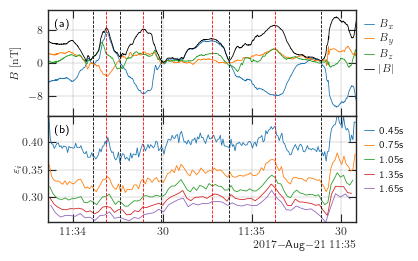

In [12]:
f, axs = plt.subplots(2, sharex="all", figsize=(4, 2.5))
f.subplots_adjust(hspace=0, left=.1, right=.87, top=.98, bottom=.13)
plot_line(axs[0], b_gsm)
plot_line(axs[0], pyrf.norm(b_gsm), color="k")
axs[0].set_ylim([-12.8, 12.8])
axs[0].set_ylabel("$B~[\\mathrm{nT}]$")
axs[0].legend(["$B_{x}$", "$B_{y}$", "$B_{z}$", "$|B|$"], frameon=False,
              loc="upper left", bbox_to_anchor=(.99, 1.), handlelength=1.)

for i in range(3, 13, 2):
    _, v_gse_i_avg, t_gse_i_avg = average_mom(n_i, v_gse_i, t_gse_i, i)
    n_i_avg, v_dbcs_i_avg, t_dbcs_i_avg = average_mom(n_i, v_dbcs_i, t_dbcs_i, i)
    vdf_i_avg = average_vdf(vdf_i_new, i)

    # Compute model distribution using averaged data
    model_vdf_i_avg = mms.make_model_vdf(vdf_i_avg, b_dmpa, sc_pot, n_i_avg,
                                         v_dbcs_i_avg, t_dbcs_i_avg)
    # Threshold energy at 0.3 v_th
    e_thresh = np.mean(pyrf.trace(t_dbcs_i_avg).data / 3) / 9
    i_thresh = np.where(vdf_i_avg.energy.data[0, :] > e_thresh)[0][0]

    # Compute non-Maxwellianity
    eps_i = mms.calculate_epsilon(vdf_i_avg, model_vdf_i_avg, n_i_avg, sc_pot,
                                  en_channels=[i_thresh, 32])
    plot_line(axs[1], eps_i, label=f"{i*0.150:3.2f}s")

axs[1].legend(frameon=False, loc="upper left", bbox_to_anchor=(.99, 1.),
              handlelength=1.)
axs[1].set_ylabel("$\\varepsilon_i$")


for ax in axs:
    for z_ in zeros:
        ax.axvline(z_, color="k", linestyle="--")

    for i in range(4):
        b_tmp = pyrf.time_clip(pyrf.norm(b_gsm), [zeros[i], zeros[i + 1]])
        maxm = b_tmp.time.data[np.argmax(b_tmp.data)]
        ax.axvline(maxm, color="r", linestyle="--")

make_labels(axs, (0.018, 0.84), pad=0, color="k")
f.align_ylabels(axs)
#f.savefig("../figures/draft/figure_si_2.pdf")
#f.savefig("../figures/draft/figure_si_2.png", dpi=200)

## Figure 3: Brazil plots with longer averaging window

In [13]:
data_3 = xr.load_dataset(
    os.path.join(
        os.getcwd(), "data", f"mms_bbfsdb_brst_2017-2021_t-anisotropy_avg_{int(3 * 150):04}.nc"
    )
)

data_5 = xr.load_dataset(
    os.path.join(
        os.getcwd(), "data", f"mms_bbfsdb_brst_2017-2021_t-anisotropy_avg_{int(5 * 150):04}.nc"
    )
)

data_7 = xr.load_dataset(
    os.path.join(
        os.getcwd(), "data", f"mms_bbfsdb_brst_2017-2021_t-anisotropy_avg_{int(7 * 150):04}.nc"
    )
)

data_9 = xr.load_dataset(
    os.path.join(
        os.getcwd(), "data", f"mms_bbfsdb_brst_2017-2021_t-anisotropy_avg_{int(9 * 150):04}.nc"
    )
)

array([<Axes: xlabel='$\\beta_{i \\parallel}$', ylabel='$T_{i \\perp} / T_{i \\parallel}$'>,
       <Axes: xlabel='$\\beta_{i \\parallel}$', ylabel='$T_{i \\perp} / T_{i \\parallel}$'>],
      dtype=object)

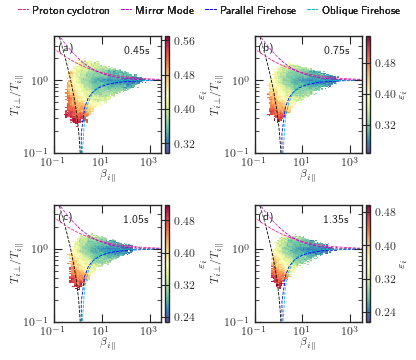

In [14]:
f, axs = plt.subplots(2, 2, figsize=(4, 3.5))
f.subplots_adjust(hspace=.45, wspace=.87, left=.115, right=.885, bottom=.105, top=.92)

for i, ax, data in zip(range(3, 10, 2), axs.reshape(4), [data_3, data_5, data_7, data_9]):
    # Compute ion plasma beta (parallel, perpendicular and total)
    b_mag = pyrf.norm(data.b_gsm)
    p_mag = 1e-18 * b_mag ** 2 / (2 * constants.mu_0)  # old
    p_i_para = 1e6 * data.n_i.data * constants.electron_volt * data.t_para_i
    p_i_perp = 1e6 * data.n_i.data * constants.electron_volt * data.t_perp_i
    beta_para = p_i_para / p_mag
    beta_perp = p_i_perp / p_mag
    beta_tota = (beta_para + 2 * beta_perp) / 3

    t_aniso = data.t_perp_i / data.t_para_i.data

    # Create 2D histogram of the (\beta_{\\parallel i}, R_i) space
    _, h_x, h_y = np.histogram2d(
        np.log10(beta_para),
        np.log10(t_aniso),
        bins=[99, 95],
        density=True,
    )
    x_bins = 10 ** (h_x[:-1] + np.median(np.diff(h_x)) / 2)
    y_bins = 10 ** (h_y[:-1] + np.median(np.diff(h_y)) / 2)

    # Counts
    n = pyrf.histogram2d(
        beta_para,
        t_aniso,
        bins=[10 ** h_x, 10 ** h_y],
        density=False,
    )
    n = n.assign_coords({"x_bins": x_bins, "y_bins": y_bins})
    n.data[n.data == 0] = np.nan

    eps_i = data.eps_i

    h_eps_i_m, h_eps_i_s = conditional_avg(eps_i, t_aniso, beta_para, n)
    ax, cax = plot_spectr(ax, h_eps_i_m, cmap="Spectral_r")
    add_threshold(ax)
    cax.set_ylabel("$\\varepsilon_i$")
    dt = np.diff(data.time.data[:2]).astype(int)[0] / 1e6
    ax.text(.65, .85, f"{i*0.150:3.2f}s", transform=ax.transAxes)
    

bbox = dict(boxstyle="square", ec=(1.0, 1.0, 1.0), fc=(1.0, 1.0, 1.0), alpha=.2)
make_labels(axs[0, :], (0.035, 0.88), pad=0, zorder=2, bbox=bbox)
make_labels(axs[1, :], (0.035, 0.88), pad=2, zorder=2, bbox=bbox)
#f.savefig("../figures/draft/figure_si_3.pdf")